<a href="https://colab.research.google.com/github/Paras-Shirvale/Model_Quantization/blob/main/Model_Quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment 11
Akshat shah(23110293)
Paras Shirvale (23110232)

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import TensorDataset, DataLoader

In [48]:
# URL of the dataset
url_train = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv"
url_test="https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv"

# Load the data
train_df = pd.read_csv(url_train, sep='\t')
test_df = pd.read_csv(url_test, sep='\t')

train_df.columns = ["sentence", "label"]
test_df.columns = ["sentence", "label"]

# Display the first few rows
display(train_df.head())

,sentence,label
0,apparently reassembled from the cutting room f...,0
1,they presume their audience wo n't sit still f...,0
2,this is a visually stunning rumination on love...,1
3,jonathan parker 's bartleby should have been t...,1
4,campanella gets the tone just right funny in t...,1


In [49]:
print("Number of columns:", train_df.shape[1])

Number of columns: 2


In [50]:
train_df.columns = ['sentence', 'label']
test_df.columns=['sentence', 'label']
print(train_df.columns)
print(test_df.columns)

Index(['sentence', 'label'], dtype='object')
Index(['sentence', 'label'], dtype='object')


In [51]:
# Split train into train/val
train_data, val_data = train_test_split(
    train_df, test_size=0.2, random_state=42, stratify=train_df["label"]
)

# Check
print(f"Train: {train_data.shape}, Validation: {val_data.shape}, Test: {test_df.shape}")


Train: (5535, 2), Validation: (1384, 2), Test: (1820, 2)


In [52]:
# Fit the vectorizer on the training data
vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(train_data['sentence']).toarray()
X_val = vectorizer.transform(val_data['sentence']).toarray()
X_test = vectorizer.transform(test_df['sentence']).toarray()

# Labels
y_train = train_data['label'].values
y_val = val_data['label'].values
y_test = test_df['label'].values


In [53]:
print(X_train.shape)  # Should be (num_samples, input_dim)

(5535, 10000)


In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [56]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.network(x)

# Initialize model
model = MLP(10000, 2)

In [57]:
# Calculate the total number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(total_params)

5293122


In [58]:
!pip install torchinfo

In [59]:
from torchinfo import summary

summary(model, input_size=(64, 10000))  # (batch_size, input_dim)

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [64, 2]                   --
├─Sequential: 1-1                        [64, 2]                   --
│    └─Linear: 2-1                       [64, 512]                 5,120,512
│    └─ReLU: 2-2                         [64, 512]                 --
│    └─Linear: 2-3                       [64, 256]                 131,328
│    └─ReLU: 2-4                         [64, 256]                 --
│    └─Linear: 2-5                       [64, 128]                 32,896
│    └─ReLU: 2-6                         [64, 128]                 --
│    └─Linear: 2-7                       [64, 64]                  8,256
│    └─ReLU: 2-8                         [64, 64]                  --
│    └─Linear: 2-9                       [64, 2]                   130
Total params: 5,293,122
Trainable params: 5,293,122
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 338.76
Input size (MB): 

In [60]:
# Test data processing
test_vec = vectorizer.transform(test_df['sentence']).toarray()
X_test_tensor = torch.tensor(test_vec, dtype=torch.float32)
X_test_tensor_16 = torch.tensor(test_vec, dtype=torch.float16)
y_test_tensor = torch.tensor(test_df['label'].values, dtype=torch.long)

In [61]:
# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Hyperparameters
input_dim = 10000
output_dim = 2
num_epochs = 10
batch_size = 64
learning_rate = 0.001

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Tracking performance
best_val_acc = 0.0
train_losses, val_losses, val_accuracies = [], [], []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    # Validation
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "checkpoint.pt")

Epoch 1/10 | Train Loss: 0.5483 | Val Loss: 0.4996 | Val Acc: 0.7738
Epoch 2/10 | Train Loss: 0.1866 | Val Loss: 0.5347 | Val Acc: 0.7673
Epoch 3/10 | Train Loss: 0.0401 | Val Loss: 0.9262 | Val Acc: 0.7594
Epoch 4/10 | Train Loss: 0.0080 | Val Loss: 1.5237 | Val Acc: 0.7551
Epoch 5/10 | Train Loss: 0.0011 | Val Loss: 2.0767 | Val Acc: 0.7673
Epoch 6/10 | Train Loss: 0.0042 | Val Loss: 1.8023 | Val Acc: 0.7652
Epoch 7/10 | Train Loss: 0.0002 | Val Loss: 2.2976 | Val Acc: 0.7587
Epoch 8/10 | Train Loss: 0.0000 | Val Loss: 2.4483 | Val Acc: 0.7616
Epoch 9/10 | Train Loss: 0.0000 | Val Loss: 2.6576 | Val Acc: 0.7645
Epoch 10/10 | Train Loss: 0.0000 | Val Loss: 2.9792 | Val Acc: 0.7645


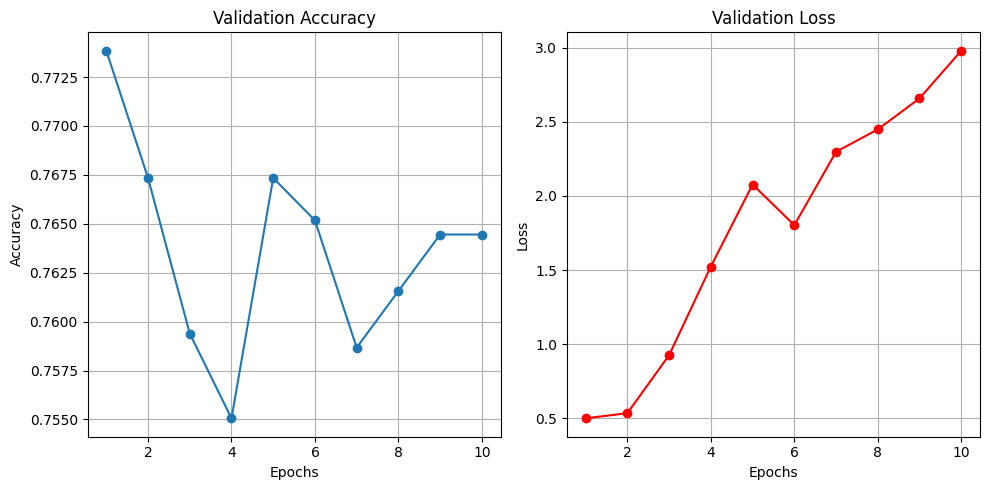

In [62]:
# Plotting
import matplotlib.pyplot as plt
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, val_losses, marker='o', color='red', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

In [63]:
from torch.quantization import quantize_dynamic

In [64]:
def print_size_of_model(model, label=""):
    import os
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (KB):', size/1e3)
    os.remove('temp.p')
    return size

In [65]:
def evaluate_accuracy(model, features,labels):
    import time
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    features = features.to(device)
    labels = labels.to(device)

    start_time = time.time()
    with torch.no_grad():
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
    inference_time = time.time() - start_time

    correct = (predicted == labels).sum().item()
    accuracy = correct / len(labels)

    return accuracy, inference_time

In [66]:
print(device)

cpu


In [67]:
def modelsize(model):
    import io
    buffer = io.BytesIO()
    torch.save(model.state_dict(), buffer)
    size = buffer.getbuffer().nbytes / (1024 * 1024)
    return size

In [68]:
model = MLP(10000, 2).to(device)
model.load_state_dict(torch.load("checkpoint.pt"))
model.eval()
size_original=modelsize(model)

acc_original,time_original = evaluate_accuracy(model, X_test_tensor, y_test_tensor)
print("Original Model Accuracy: {:.8f}%".format(acc_original * 100))
print("Original Model Inference Time: {:.4f} seconds".format(time_original))
print("Model size (MB):", size_original)

Original Model Accuracy: 79.06593407%
Original Model Inference Time: 0.3154 seconds
Model size (MB): 20.19481658935547


In [69]:
model = MLP(10000, 2).to(device)
model.load_state_dict(torch.load("checkpoint.pt"))
model.eval()
quantized_model = torch.quantization.quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)
# For quantized model (must stay on CPU)
acc_int8,time_int8= evaluate_accuracy(quantized_model, X_test_tensor, y_test_tensor)
sizeint8=modelsize(quantized_model)

print("Quantized model accuracy: ", acc_int8*100, "%")
print("Quantized model inference time: {:.4f} seconds ".format(time_int8))
print("Quantized model size: ", sizeint8, "MB")

Quantized model accuracy:  79.34065934065934 %
Quantized model inference time: 0.2261 seconds 
Quantized model size:  5.057214736938477 MB


In [70]:
model = MLP(10000, 2).to(device)
model.load_state_dict(torch.load("checkpoint.pt"))
model=model.half()
model.eval()

acc_16,time_16 = evaluate_accuracy(model, X_test_tensor_16, y_test_tensor)
size16=modelsize(model)
print("Quantized model accuracy: ", acc_16*100, "%")
print("Model inference time (FP16): {:.4f} seconds".format(time_16))
print("Model size (MB):", size16)

Quantized model accuracy:  79.06593406593406 %
Model inference time (FP16): 2.5972 seconds
Model size (MB): 10.098991394042969


In [71]:
# Convert inference times from seconds to milliseconds
time_original_ms = time_original * 1000
time_int8_ms = time_int8 * 1000
time_16_ms = time_16 * 1000

# Create a dictionary of the results
results = {
    "Model Name": ["Original", "Dynamic", "Half"],
    "Accuracy (Out of 100)": [acc_original * 100, acc_int8 * 100, acc_16 * 100],
    "Storage (In MB)": [size_original, sizeint8, size16],
    "Inference Time (In ms)": [time_original_ms, time_int8_ms, time_16_ms]
}

# Create the DataFrame
df = pd.DataFrame(results)

# Format floats to 4 decimal places
pd.options.display.float_format = '{:,.4f}'.format

# Print the DataFrame
print(df)

  Model Name  Accuracy (Out of 100)  Storage (In MB)  Inference Time (In ms)
0   Original                79.0659          20.1948                315.4037
1    Dynamic                79.3407           5.0572                226.1090
2       Half                79.0659          10.0990              2,597.2493


In [72]:
# ======== FP32 MODEL ========
model_fp32 = MLP(10000, 2).to(device)
model_fp32.load_state_dict(torch.load("checkpoint.pt"))
model_fp32.eval()

acc_fp32, time_fp32 = evaluate_accuracy(model_fp32, X_test_tensor, y_test_tensor)
size_fp32 = modelsize(model_fp32)

print("FP32 Model Accuracy: {:.8f}%".format(acc_fp32 * 100))
print("FP32 Inference Time: {:.4f} seconds".format(time_fp32))
print("FP32 Model Size (MB):", size_fp32)

# ======== INT8 QUANTIZED MODEL (CPU ONLY) ========
model_cpu = MLP(10000, 2)
model_cpu.load_state_dict(torch.load("checkpoint.pt", map_location='cpu'))
model_cpu.eval()

quantized_model = torch.quantization.quantize_dynamic(model_cpu, {nn.Linear}, dtype=torch.qint8)

# Move test data to CPU
X_cpu = X_test_tensor.cpu()
y_cpu = y_test_tensor.cpu()

acc_int8, time_int8 = evaluate_accuracy(quantized_model, X_cpu, y_cpu)
size_int8 = modelsize(quantized_model)

print("INT8 Quantized Model Accuracy: {:.8f}%".format(acc_int8 * 100))
print("INT8 Inference Time: {:.4f} seconds".format(time_int8))
print("INT8 Model Size (MB):", size_int8)

# ======== FP16 MODEL (NO QUANTIZATION, GPU ONLY) ========
model_fp16 = MLP(10000, 2).to(device)
model_fp16.load_state_dict(torch.load("checkpoint.pt"))
model_fp16 = model_fp16.half()
model_fp16.eval()

# Ensure input is half precision and on GPU
acc_fp16, time_fp16 = evaluate_accuracy(model_fp16, X_test_tensor_16.half(), y_test_tensor)
size_fp16 = modelsize(model_fp16)

print("FP16 Model Accuracy: {:.8f}%".format(acc_fp16 * 100))
print("FP16 Inference Time: {:.4f} seconds".format(time_fp16))
print("FP16 Model Size (MB):", size_fp16)


FP32 Model Accuracy: 79.06593407%
FP32 Inference Time: 0.4881 seconds
FP32 Model Size (MB): 20.19481658935547
INT8 Quantized Model Accuracy: 79.34065934%
INT8 Inference Time: 0.2079 seconds
INT8 Model Size (MB): 5.057214736938477
FP16 Model Accuracy: 79.06593407%
FP16 Inference Time: 2.8653 seconds
FP16 Model Size (MB): 10.098991394042969
